# Rating Predictor for Yelp Reviews

In [2]:
# Import libraries
import requests
import json
import time
import pandas as pd
from bs4 import BeautifulSoup

import seaborn as sns
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np

import string

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

import pickle
from sklearn.svm import SVC

## Rating Prediction based on User Reviews
As an application based on previous discoveries and priors, we designed a rating prediction algorithm providing supportings for users. Based on the text of restaurant reviews written by users, a star suggestion can be generated by analysing the sentiment from the words.

This work is a part of Natural language processing (or NLP), mainly focus on analyse sentiment, such as positive and negative words from the text. The basic steps of solving this kind of problems includes data pre-processing, feature extraction, training by machine learning methods and result evaluation. We will explain each step in the following.


### Pre-processing

Text pre-processing is an important step for the prediction, because usually, data we get from website are dirty with much information we don't want for training, which are meaningless and evem may have negative influence to our performance.

For our data, we focus on the relationship between review text and rating user gave for each review. Our raw data collected from Yelp website contains NaN, 0.0 for ratings, thus thoses rows will be removed. Also, we want to take review length into consideration, trying to find out if there is relationship between length of reviews and ratings people give.

In [9]:
# After data has been scraped, read raw data directly from csv file.
df = pd.read_csv(open('reviews.csv','rU'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


In [14]:
def pre_process(df):
    new_df = df
    # Extract reviews and ratings
    new_df = new_df[['text', 'rating']]
    
    # remove invalid rows with ",text,rating"
    new_df = new_df[new_df.rating.astype(str).str.contains("rating") == False]

    # convert rating values to float
    new_df['rating'] = new_df['rating'].astype(float).fillna(0)
    
    # add length column to record word count of reviews
    new_df['length'] = new_df['text'].astype(str).apply(word_count)

    new_df = new_df[(new_df.rating >= 1.0)]
    
    return new_df
    
def word_count(str):
    return len(str.split())

# Dataset size before pre-process
print ('Data rows before process: ' + str(len(df)))

df = pre_process(df)

# Dataset size after pre-process
print('Data rows after process: ' + str(len(df)))

Data rows before process: 187864
Data rows after process: 187075


### Dataset Visualization
After one step of data extraction and cleaning from original data scraped from website. In this part, we will show some facts we found by simply anaysing the raw text and word length for each of them. We mainly did visualiazation on relationship between word number and rating.

- #### Review Length v.s  Rating (absolute)

    This graph shows the review length distribution for each rating. Y-axis displays the absolute number of reviews falling in each bin.

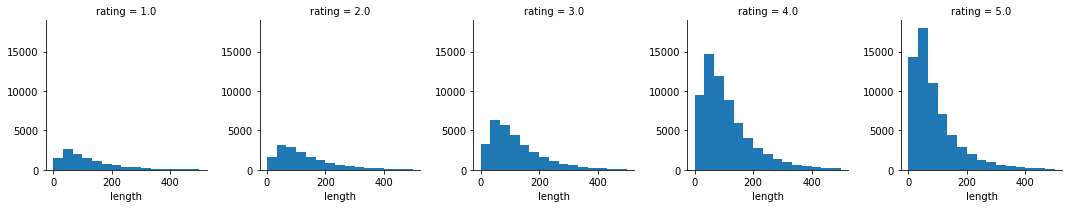

In [18]:
# dataframe df as input, separated by ratings.
g = sns.FacetGrid(data=df, col='rating')
# Drow histogram, x-axis is word number, y-axis is number of each bin.
g.map(plt.hist, 'length', bins=15, range = (0,500))
# display
plt.show()

- #### Review length v.s Rating (relative)

    As the number of reviews for each rating are different, the previous distribution may not reflect the distribution in each rating clearly. So, we further did visualization in relative way, so that the distribution in each subplot is standalone.

mean = 131.31633864947403


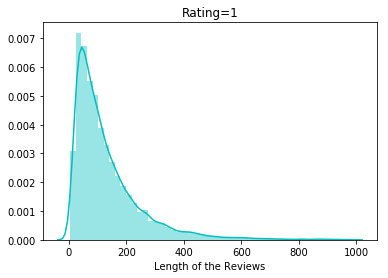

mean = 135.40501361017914


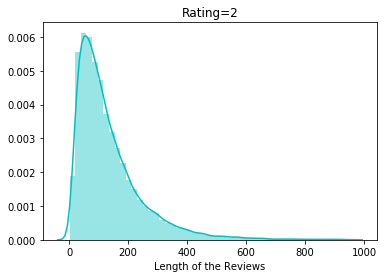

mean = 127.28331969225732


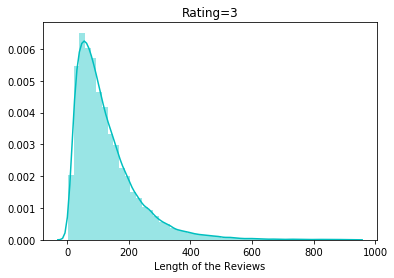

mean = 115.35467781908302


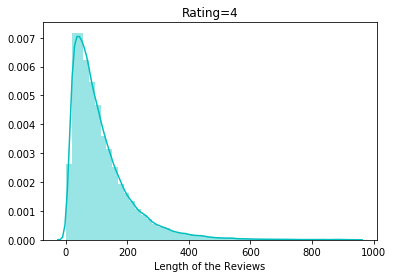

mean = 95.52085112992157


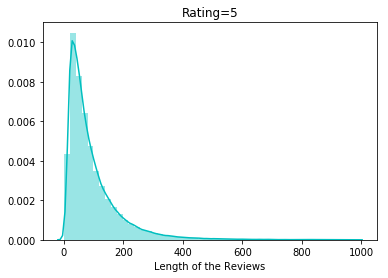

In [25]:
# Store average length for each rating
average_length_list = []

# Loop each rating
for rating in range(1, 6):
    # Extract the dataframe with this rating
    rating_curr = df[(df.rating == rating)]
    
    # Plot by taking this sub-df as input
    plot = sns.distplot(rating_curr['length'],label='rating='+str(rating),axlabel='Length of the Reviews',color="c")
    
    # Set title
    plt.title('Rating='+str(rating))
    
    # Save the figure as image
    fig = plot.get_figure()
    fig.savefig('rating_' + str(rating) + '.png')
    
    # Display the average length for each rating
    print ('mean =',np.mean(rating_curr['length']))
    
    # update list
    average_length_list.append(np.mean(rating_curr['length']))
    
    # Display figure
    plt.show()

- #### Average Length of Each Rating

    Based on the previous exploration, we found the average review length for each rating is different. 
    
    What's more, the length and rating shows a trends: **People tends to write longer reviews when giving low ratings, while they prefer to write less words in reviews when giving high ratings.**
    
    As we can see, the average length for 5-star is only 95.52 words, while the average word number is more than 130 for 2-star and 1-star.

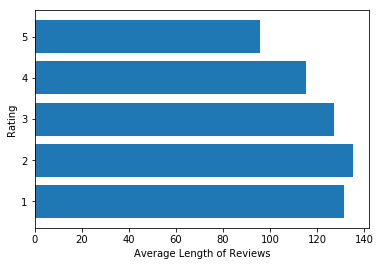

In [27]:
# There are totally 5 classes of rating, from 1 to 5.
rating_classes = [1,2,3,4,5]

fig, ax = plt.subplots()

# Plot by bar graph
plt.barh(rating_classes, average_length_list)

# Label in x and y-axis
ax.set_xlabel('Average Length of Reviews')
ax.set_ylabel('Rating')

# Save the figure
plt.savefig("average_length.png")

# Display
plt.show()

- #### Number of Reviews for Each Rating

    First, we show the number of reviews for each rating. We found that people tends to write longer reviews as the number of reviews rated 4-star and 5-star contains nearly 70% of the total.

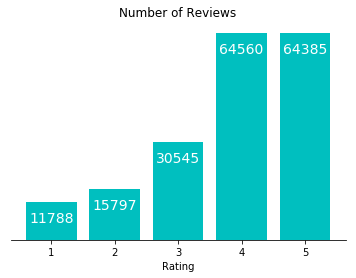

In [28]:
# Number of reviews of each rating
rating_size = [len(df[df.rating == 1.0]), len(df[df.rating == 2.0]), len(df[df.rating == 3.0]), \
              len(df[df.rating == 4.0]), len(df[df.rating == 5.0])]

fig, ax = plt.subplots()

# Draw a bar graph
plt.bar(rating_classes, rating_size, color = 'c')

# Set x-label
ax.set_xlabel('Rating')

# Set title
plt.title('Number of Reviews')

# Write number of reviews in each bar
for i, (rating_a, size_a) in enumerate(zip(rating_classes, rating_size)):
    plt.text(s=str(size_a), x=i+0.65, y=size_a-5000, color="w",
             verticalalignment="center", horizontalalignment="left", size=14)

# Remove the line borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.yaxis.set_ticks([])

# Save figure
plt.savefig("reviews_size.png")

# Display
plt.show()


## Pre-process (Cont.)

In [ ]:
# remove stopwords, punctuations, to lower case
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

### 5-Class Training

In [ ]:
five = df[(df.rating >= 1.0)]
X = five.text
y = five.rating


## Feature Extraction

Putting the whole text into machine learning framework is the most straight-forward but less effective way with bad performance for the task of prediction. Usually, feature extraction is involved in the prediction pipeline. There are many ways to extract feature for text, such as Document Frequency, Mutual Information, Information Gain, Chi-squre, Weighted Log Likelihood Ration, etc.

In our approach, we use CountVectorizer from sklearn library for feature extraction. By counting the apprearance of the words, implementing the idea of bag-of and put it in a sparse vector as feature.

### Binary Classification

To simplify, we firstly consider this problem as a binay classification problem. We take one-star as *negative set*, and five-star as *positive set*.

In [ ]:
# Extract positive and negative data
binary = df[(df.rating == 1.0) | (df.rating == 5.0)]

# feature data
X = binary.text

# Groundtruth data
y = binary.rating

In [ ]:
# Because this takes long time to execute
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

# This takes lo
filehandler = open('bow_transformer', 'wb')
pickle.dump(bow_transformer, filehandler)
filehandler.close()

#### Show the effect of tranformer

In [ ]:
review_25 = X.iloc[24]
print(review_25)
bow_25 = bow_transformer.transform([review_25])
print(bow_25)

#### Transform the whole training set

In [ ]:
X_ = bow_transformer.transform(X)

filehandler = open('X_', 'wb')
pickle.dump(X_, filehandler)
filehandler.close()

## Train the Model using Naive Bayes

### Split the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=101)

### Train by Naive Bayes

In [ ]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

### Predict

In [ ]:
preds = nb.predict(X_test)
print(len(preds))

### Evaluate

In [ ]:
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds)) 

### Average Error

In [ ]:
y_test_ = np.array(y_test.tolist())

import numpy as np
print(np.average(np.absolute(preds - y_test)))

## Result Visualiaztion

### Get average

In [ ]:
pred_1 = [preds[index] for index, value in enumerate(y_test) if value == 1.0]
pred_1_avg = np.mean(pred_1)
print(len(pred_1))
pred_2 = [preds[index] for index, value in enumerate(y_test) if value == 2.0]
pred_2_avg = np.mean(pred_2)
print(len(pred_2))
pred_3 = [preds[index] for index, value in enumerate(y_test) if value == 3.0]
pred_3_avg = np.mean(pred_3)
print(len(pred_3))
pred_4 = [preds[index] for index, value in enumerate(y_test) if value == 4.0]
pred_4_avg = np.mean(pred_4)
print(len(pred_4))
pred_5 = [preds[index] for index, value in enumerate(y_test) if value == 5.0]
pred_5_avg = np.mean(pred_5)
print(len(pred_5))

pred_avg = [pred_1_avg, pred_2_avg, pred_3_avg, pred_4_avg, pred_5_avg]
print(pred_avg)


### Visualization

In [ ]:
fig, ax = plt.subplots()

n_groups = 5

means_men = pred_avg
means_women = [1,2,3,4,5]

index = np.arange(n_groups)
bar_width = 0.35

error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, means_men, bar_width,color='g', label='Prediction')

rects2 = ax.bar(index + bar_width, means_women, bar_width, color='c', label='Ground Truth')

ax.set_xlabel('Groups')
ax.set_ylabel('Ratings')
ax.set_title('Rating comparision between prediction and groundtruth')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('1', '2', '3', '4', '5'))
ax.legend()

fig.tight_layout()
plt.savefig("prediction.png")
plt.show()

## SVM (optional)

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)

In [ ]:
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

print(clf.predict(X_test))